In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import numpy as np
%matplotlib inline
torch.cuda.manual_seed_all(1)
torch.manual_seed(1)
np.random.seed(1)

In [0]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, bias=False)#input:28x28x1, output:26x26x16, RF:3x3
        self.conv1_bn1 = nn.BatchNorm2d(16)
        self.conv1_drop1 = nn.Dropout2d(0.03)

        self.conv2 = nn.Conv2d(16, 16, 3, bias=False)#input:26x26x16, output:24x24x16, RF:5x5 
        self.conv2_bn2 = nn.BatchNorm2d(16)
        self.conv2_drop2 = nn.Dropout2d(0.03)
        self.conv3 = nn.Conv2d(16, 16, 3, bias=False)#input:24x24x16, output:22x22x16, RF:7x7
        self.conv3_bn3 = nn.BatchNorm2d(16)
        self.conv3_drop3 = nn.Dropout2d(0.03)

        self.pool1 = nn.MaxPool2d(2, 2)#input:22x22x16, output:11x11x16, RF:8x8  
        self.conv4 = nn.Conv2d(16, 16, 1, bias=False)#input:11x11x16, output:11x11x16, RF:8x8
        self.conv4_bn4 = nn.BatchNorm2d(16)
        self.conv4_drop4 = nn.Dropout2d(0.03)

        self.conv5 = nn.Conv2d(16, 24, 3, bias=False)#input:11x11x16, output:9x9x24, RF:12x12 
        self.conv5_bn5 = nn.BatchNorm2d(24)
        self.conv5_drop5 = nn.Dropout2d(0.03)
        self.conv6 = nn.Conv2d(24, 24, 3, bias=False)#input:9x9x24, output:7x7x24, RF:16x16
        self.conv6_bn6 = nn.BatchNorm2d(24)
        self.conv6_drop6 = nn.Dropout2d(0.03)
        
        self.conv7 = nn.Conv2d(24, 10, 1, bias=False)#input:7x7x24, output:7x7x10, RF:16x16
        self.gap1 = nn.AvgPool2d(kernel_size=7)#input:7x7x10, output:1x1x10 (or 1x10, 1-D data format now)
        
    def forward(self, x):
        x = F.relu(self.conv1_drop1(self.conv1_bn1(self.conv1(x))))#First Layer Separate
        x = F.relu(self.conv3_drop3(self.conv3_bn3(self.conv3(F.relu(self.conv2_drop2(self.conv2_bn2(self.conv2(x))))))))#First Block
        x = F.relu(self.conv4_drop4(self.conv4_bn4(self.conv4(self.pool1(x)))))#First transition block
        x = F.relu(self.conv6_drop6(self.conv6_bn6(self.conv6(F.relu(self.conv5_drop5(self.conv5_bn5(self.conv5(x))))))))#Second Block 
        x = self.conv7(x)#no ReLU at 2nd Transition Block O/p(just 1x1, without a maxpool towards the end here)leading to GAP & beyond) 
        x = self.gap1(x) # Global Average Pool layer
        x = x.view(-1, 10)#Num of classes = 10 (digits to be identified)
        return F.log_softmax(x, dim=1)

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model5 = Net5().to(device)
summary(model5, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,304
       BatchNorm2d-5           [-1, 16, 24, 24]              32
         Dropout2d-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           2,304
       BatchNorm2d-8           [-1, 16, 22, 22]              32
         Dropout2d-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 16, 11, 11]             256
      BatchNorm2d-12           [-1, 16, 11, 11]              32
        Dropout2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [-1, 2

In [0]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [0]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    acc=0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred_train = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred_train.eq(target.view_as(pred_train)).sum().item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc=f'epoch={epoch} loss={loss.item()} batch_id={batch_idx}')
    train_loss = loss.item()
    acc = 100. * train_correct / len(train_loader.dataset)
    print('\nEpoch {}--Train set: Average loss: {:.4f}, Training Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)))
    return acc, train_loss


def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    acc=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nEpoch {}--Test set: Average loss: {:.4f}, Validation Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return acc, test_loss

In [11]:
model5 = Net5().to(device)
optimizer = optim.SGD(model5.parameters(), lr=0.01, momentum=0.9)
acc_history = []
loss_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 21):
    acc, train_loss = train(model5, device, train_loader, optimizer, epoch)
    val_acc, test_loss = test(model5, device, test_loader, epoch)
    acc_history.append(acc)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    val_loss_history.append(test_loss)

epoch=1 loss=0.21764731407165527 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.40it/s]


Epoch 1--Train set: Average loss: 0.2176, Training Accuracy: 50722/60000 (84.54%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 1--Test set: Average loss: 0.0897, Validation Accuracy: 9791/10000 (97.91%)



epoch=2 loss=0.06962326169013977 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 58.42it/s]


Epoch 2--Train set: Average loss: 0.0696, Training Accuracy: 57869/60000 (96.45%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2--Test set: Average loss: 0.0529, Validation Accuracy: 9848/10000 (98.48%)



epoch=3 loss=0.06028956174850464 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 58.40it/s]


Epoch 3--Train set: Average loss: 0.0603, Training Accuracy: 58436/60000 (97.39%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3--Test set: Average loss: 0.0381, Validation Accuracy: 9890/10000 (98.90%)



epoch=4 loss=0.03670795261859894 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.96it/s]



Epoch 4--Train set: Average loss: 0.0367, Training Accuracy: 58675/60000 (97.79%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4--Test set: Average loss: 0.0342, Validation Accuracy: 9896/10000 (98.96%)



epoch=5 loss=0.014482080936431885 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 58.90it/s]



Epoch 5--Train set: Average loss: 0.0145, Training Accuracy: 58736/60000 (97.89%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 5--Test set: Average loss: 0.0302, Validation Accuracy: 9906/10000 (99.06%)



epoch=6 loss=0.03699415922164917 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.43it/s]


Epoch 6--Train set: Average loss: 0.0370, Training Accuracy: 58877/60000 (98.13%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 6--Test set: Average loss: 0.0271, Validation Accuracy: 9919/10000 (99.19%)



epoch=7 loss=0.014394938945770264 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.38it/s]



Epoch 7--Train set: Average loss: 0.0144, Training Accuracy: 58961/60000 (98.27%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7--Test set: Average loss: 0.0255, Validation Accuracy: 9919/10000 (99.19%)



epoch=8 loss=0.07803086936473846 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.59it/s]


Epoch 8--Train set: Average loss: 0.0780, Training Accuracy: 58978/60000 (98.30%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8--Test set: Average loss: 0.0249, Validation Accuracy: 9916/10000 (99.16%)



epoch=9 loss=0.06453123688697815 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 57.78it/s]



Epoch 9--Train set: Average loss: 0.0645, Training Accuracy: 59031/60000 (98.39%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9--Test set: Average loss: 0.0231, Validation Accuracy: 9933/10000 (99.33%)



epoch=10 loss=0.02337595820426941 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 57.73it/s]



Epoch 10--Train set: Average loss: 0.0234, Training Accuracy: 59111/60000 (98.52%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10--Test set: Average loss: 0.0223, Validation Accuracy: 9927/10000 (99.27%)



epoch=11 loss=0.11296353489160538 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.74it/s]


Epoch 11--Train set: Average loss: 0.1130, Training Accuracy: 59104/60000 (98.51%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 11--Test set: Average loss: 0.0223, Validation Accuracy: 9928/10000 (99.28%)



epoch=12 loss=0.20057690143585205 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 58.14it/s]


Epoch 12--Train set: Average loss: 0.2006, Training Accuracy: 59122/60000 (98.54%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 12--Test set: Average loss: 0.0212, Validation Accuracy: 9937/10000 (99.37%)



epoch=13 loss=0.17706504464149475 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.62it/s]



Epoch 13--Train set: Average loss: 0.1771, Training Accuracy: 59165/60000 (98.61%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 13--Test set: Average loss: 0.0211, Validation Accuracy: 9935/10000 (99.35%)



epoch=14 loss=0.052569061517715454 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.92it/s]



Epoch 14--Train set: Average loss: 0.0526, Training Accuracy: 59231/60000 (98.72%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 14--Test set: Average loss: 0.0216, Validation Accuracy: 9928/10000 (99.28%)



epoch=15 loss=0.016775235533714294 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 58.14it/s]



Epoch 15--Train set: Average loss: 0.0168, Training Accuracy: 59196/60000 (98.66%)



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 15--Test set: Average loss: 0.0212, Validation Accuracy: 9934/10000 (99.34%)



epoch=16 loss=0.03582005202770233 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.22it/s]


Epoch 16--Train set: Average loss: 0.0358, Training Accuracy: 59266/60000 (98.78%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 16--Test set: Average loss: 0.0207, Validation Accuracy: 9932/10000 (99.32%)



epoch=17 loss=0.008993446826934814 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 58.98it/s]


Epoch 17--Train set: Average loss: 0.0090, Training Accuracy: 59241/60000 (98.73%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 17--Test set: Average loss: 0.0189, Validation Accuracy: 9935/10000 (99.35%)



epoch=18 loss=0.013608992099761963 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.91it/s]


Epoch 18--Train set: Average loss: 0.0136, Training Accuracy: 59305/60000 (98.84%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 18--Test set: Average loss: 0.0186, Validation Accuracy: 9941/10000 (99.41%)



epoch=19 loss=0.07923413068056107 batch_id=937: 100%|██████████| 938/938 [00:16<00:00, 58.62it/s]


Epoch 19--Train set: Average loss: 0.0792, Training Accuracy: 59272/60000 (98.79%)




  0%|          | 0/938 [00:00<?, ?it/s]


Epoch 19--Test set: Average loss: 0.0197, Validation Accuracy: 9938/10000 (99.38%)



epoch=20 loss=0.0036350637674331665 batch_id=937: 100%|██████████| 938/938 [00:15<00:00, 59.35it/s]


Epoch 20--Train set: Average loss: 0.0036, Training Accuracy: 59286/60000 (98.81%)




Epoch 20--Test set: Average loss: 0.0179, Validation Accuracy: 9942/10000 (99.42%)



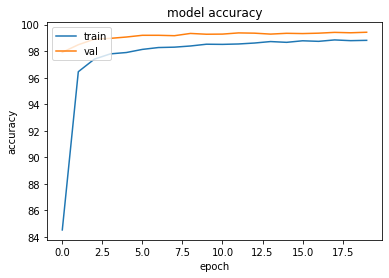

In [12]:
_= plt.plot(acc_history)
_= plt.plot(val_acc_history)
_= plt.title('model accuracy')
_= plt.ylabel('accuracy')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

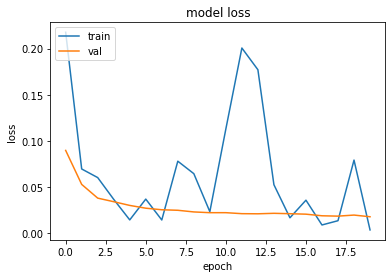

In [13]:
_= plt.plot(loss_history)
_= plt.plot(val_loss_history)
_= plt.title('model loss')
_= plt.ylabel('loss')
_= plt.xlabel('epoch')
_= plt.legend(['train', 'val'], loc='upper left')
_= plt.show()

Total params: 14,112 (which is expected,given higher NW capacity) & the max validation accuracy reaches: ~99.42%

This case meets the required goal of getting an accuracy of 99.4% (appeared 2 times during training-epochs), the parameters: 14,112 < 20K (requirement) and came under 20 epochs.
